In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, \
  Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
#Upload the data BX-Book-Ratings.csv
from google.colab import files
uploaded = files.upload()

Saving BX-Book-Ratings.csv to BX-Book-Ratings.csv


In [16]:
!ls

'BX-Book-Ratings (1).csv'   BX-Books.csv      BX-Users.csv
 BX-Book-Ratings.csv	    BX-CSV-Dump.zip   sample_data


In [19]:
df = pd.read_csv('BX-Book-Ratings.csv', encoding= 'unicode_escape')
df.head()

,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410887 entries, 0 to 410886
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   UserID  410887 non-null  int64 
 1   ISBN    410887 non-null  object
 2   Rating  410887 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.4+ MB


In [25]:
df.describe()

,UserID,Rating
count,410887.000000,410887.000000
mean,54491.619304,3.085393
std,44425.842330,3.925907
min,2.000000,0.000000
25%,25981.000000,0.000000
50%,50225.000000,0.000000
75%,76352.000000,7.000000
max,278854.000000,10.000000


In [26]:
df.UserID = pd.Categorical(df.UserID)
df['new_user_id'] = df.UserID.cat.codes

In [27]:
df.ISBN = pd.Categorical(df.ISBN)
df['new_ISBN'] = df.ISBN.cat.codes

In [29]:
# Get user IDs, ISBNs, and ratings as separate arrays
user_ids = df['new_user_id'].values
isbn_ids = df['new_ISBN'].values
ratings = df['Rating'].values

In [30]:
# Get number of users and number of books
N = len(set(user_ids))
M = len(set(isbn_ids))

# Set embedding dimension
K = 10

In [31]:
# Make a neural network

# User input
u = Input(shape=(1,))

# ISBN input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
# x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [32]:
# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [33]:
# split the data
user_ids, isbn_ids, ratings = shuffle(user_ids, isbn_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_isbn = isbn_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_isbn = isbn_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [34]:
r = model.fit(
  x=[train_user, train_isbn],
  y=train_ratings,
  epochs=25,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_isbn], test_ratings),
)

Epoch 1/25
322/322 - 5s - loss: 12.5956 - val_loss: 12.0946 - 5s/epoch - 15ms/step
Epoch 2/25
322/322 - 4s - loss: 11.5183 - val_loss: 11.8141 - 4s/epoch - 12ms/step
Epoch 3/25
322/322 - 4s - loss: 10.9859 - val_loss: 12.1276 - 4s/epoch - 12ms/step
Epoch 4/25
322/322 - 4s - loss: 10.4226 - val_loss: 15.7379 - 4s/epoch - 12ms/step
Epoch 5/25
322/322 - 4s - loss: 9.9329 - val_loss: 13.6728 - 4s/epoch - 11ms/step
Epoch 6/25
322/322 - 4s - loss: 9.3687 - val_loss: 17.7556 - 4s/epoch - 11ms/step
Epoch 7/25
322/322 - 4s - loss: nan - val_loss: nan - 4s/epoch - 12ms/step
Epoch 8/25
322/322 - 4s - loss: nan - val_loss: nan - 4s/epoch - 11ms/step
Epoch 9/25
322/322 - 4s - loss: nan - val_loss: nan - 4s/epoch - 12ms/step
Epoch 10/25
322/322 - 4s - loss: nan - val_loss: nan - 4s/epoch - 11ms/step
Epoch 11/25
322/322 - 4s - loss: nan - val_loss: nan - 4s/epoch - 12ms/step
Epoch 12/25
322/322 - 4s - loss: nan - val_loss: nan - 4s/epoch - 12ms/step
Epoch 13/25
322/322 - 4s - loss: nan - val_loss: na

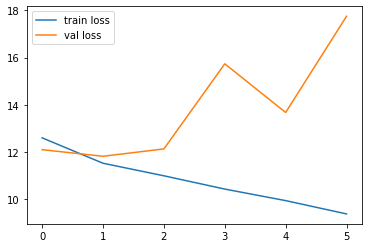

In [35]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()